### Setup & SQLite Connection

In [44]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [19]:
# Define relative path 
DATA_DIR = Path("../data")
file_path = DATA_DIR / "Telco_customer_churn.xlsx"

assert file_path.exists(), f"Dataset not found at {file_path}."

# Load Excel file
df = pd.read_excel(file_path)
# Create SQLite connection
conn = sqlite3.connect(":memory:")
#Save DataFrame as a SQL table
df.to_sql("telco",conn,index=False,if_exists="replace")
print("Database ready with table telco")

Database ready with table telco


### Churn Distribution
To begin, we will calculate the overall churn rate to understand the scale of the problem. Knowing the baseline churn is important because it guides model evaluation.

In [117]:
query = """
SELECT [Churn Label],
       COUNT(*) AS total_customers,
       ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM telco), 2) AS pct_customers
FROM telco
GROUP BY [Churn Label];
"""
pd.read_sql_query(query, conn)

,Churn Label,total_customers,pct_customers
0,No,5174,73.46
1,Yes,1869,26.54


Churn rate is about 27%. This indicates moderate class imbalance(most customers stay,some leave). Predictive models must optimise recall for churners, not just overall accuracy. 

### Churn by Contact Type
The next step is to look for the contract type as it is a strong behavioral indicator. Customets on shorter contracts may feel less committed. 

In [121]:
query = """
SELECT Contract,
       COUNT(*) AS total_customers,
       SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) AS churned_customers,
       ROUND(100.0 * SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) / COUNT(*),2) AS churn_rate
FROM telco
GROUP BY Contract
ORDER BY churn_rate DESC;
"""
pd.read_sql_query(query,conn)

,Contract,total_customers,churned_customers,churn_rate
0,Month-to-month,3875,1655,42.71
1,One year,1473,166,11.27
2,Two year,1695,48,2.83


Customers with month to month contracts churn at almost 43%,compared to only 3-11% for one and two year contracts.
This shows contact type is a strong predictor of churn and an important business lever.

### Churn by Payment Method
Next, we will see how payment influences churn. Some methods indicate less stable customer relationships.

In [125]:
query="""
SELECT [Payment Method],
        COUNT(*) AS total_customers,
        SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) AS churned_customers,
        ROUND(100.0 * SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) / COUNT(*),2) AS churn_rate
FROM telco
GROUP BY [Payment Method]
ORDER BY churn_rate DESC;
"""
pd.read_sql_query(query,conn)

,Payment Method,total_customers,churned_customers,churn_rate
0,Electronic check,2365,1071,45.29
1,Mailed check,1612,308,19.11
2,Bank transfer (automatic),1544,258,16.71
3,Credit card (automatic),1522,232,15.24


Payment method is important as can reveal behavioral churn patterns.
Customers who pay electronically might be more month to month and less sticky. Churn isn't just about customer counts but it is also about lost revenue.

### Revenue Impart of Churn

In [30]:
query = """
SELECT [Churn Value],                               
       ROUND(AVG([Monthly Charges]), 2) AS avg_monthly_charge,  
       ROUND(SUM([Monthly Charges]), 2) AS total_revenue,
       ROUND(100.0 * SUM([Monthly Charges]) / (SELECT SUM([Monthly Charges]) FROM telco), 2) AS pct_revenue
FROM telco
GROUP BY [Churn Value];
"""
pd.read_sql_query(query, conn)

,Churn Value,avg_monthly_charge,total_revenue,pct_revenue
0,0,61.27,316985.75,69.5
1,1,74.44,139130.85,30.5


Churners represent around 30% of montly revenue, despite being a smaller share of customers.Retention efforts should prioritize this high-value group.

### Churn by Tenure Buckets
Our next step is to identify how churners behave on tenures.

In [114]:
query = """
SELECT CASE 
          WHEN [Tenure Months] < 12 THEN '0-12 months'
          WHEN[Tenure Months] < 24 THEN '12-24 months'
          WHEN [Tenure Months] < 48 THEN '24-48 months'
          ELSE '48+ months'
       END AS tenure_group,                                -- create tenure buckets
       COUNT(*) AS total_customers,                        -- total in each bucket
       SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) AS churned_customers,
       ROUND(100.0 * SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate
FROM telco
GROUP BY tenure_group
ORDER BY tenure_group;
"""
pd.read_sql_query(query, conn)

,tenure_group,total_customers,churned_customers,churn_rate
0,0-12 months,2069,999,48.28
1,12-24 months,1047,309,29.51
2,24-48 months,1624,339,20.87
3,48+ months,2303,222,9.64


Churn is highest in the first year(0-12 months: 48%) and decreases with longer tenure. By the 4th year, churn is below 10%. 

### Churn by Internet Service

In [138]:
query = """
SELECT [Internet Service],
        COUNT(*) AS total_customers,
        SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) AS churned_customers,
        ROUND(100.0 * SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) / COUNT(*),2) AS churn_rate
FROM telco
GROUP BY [Internet Service]
ORDER BY churn_rate DESC;
"""
pd.read_sql_query(query,conn)

,Internet Service,total_customers,churned_customers,churn_rate
0,Fiber optic,3096,1297,41.89
1,DSL,2421,459,18.96
2,No,1526,113,7.40


Fiber optic customers churn the most, while DSL churns less, and No Internet customers churn the least. Customers who subcribe to more services may be less likely to churn. To test this, we will count the number of add-on services each customer has and compare churn rates across groups.

### Churn by Number of Services

In [150]:
query = """
SELECT 
    (CASE WHEN [Online Security] = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN [Online Backup] = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN [Device Protection] = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN [Tech Support] = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN [Streaming TV] = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN [Streaming Movies] = 'Yes' THEN 1 ELSE 0 END) As num_services,
    COUNT(*) As total_customers,
    SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) As churned_customers
FROM telco
GROUP BY num_services
ORDER BY num_services;
"""
pd.read_sql_query(query,conn)

,num_services,total_customers,churned_customers
0,0,2219,475
1,1,966,442
2,2,1033,370
3,3,1118,306
4,4,852,190
5,5,571,71
6,6,284,15


Customers with 0-1 services churn at aroun 50% while those with 4+ services churn under 10%. Bundling services significantly increases customer stickiness. Offering service packages or upsells could be an effective retention strategy. 

### Cross Analysis (Churn by Contract + Payment Method)
Next, we will do a cross analysis to identify which contract + payment method combinations carry the highest risk. We know from before the contract type and payment method are both storng churn predictors individually. But what if we combine them?

In [36]:
query = """
SELECT Contract, [Payment Method],
        COUNT (*) AS total_customers,
        SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) AS churned_customers,
        ROUND(100.0 * SUM(CASE WHEN [Churn Value] = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate
FROM telco
GROUP BY Contract, [Payment Method]
ORDER BY churn_rate DESC;
"""
df_contract_payment=pd.read_sql_query(query,conn)

### Heatmap Visualization

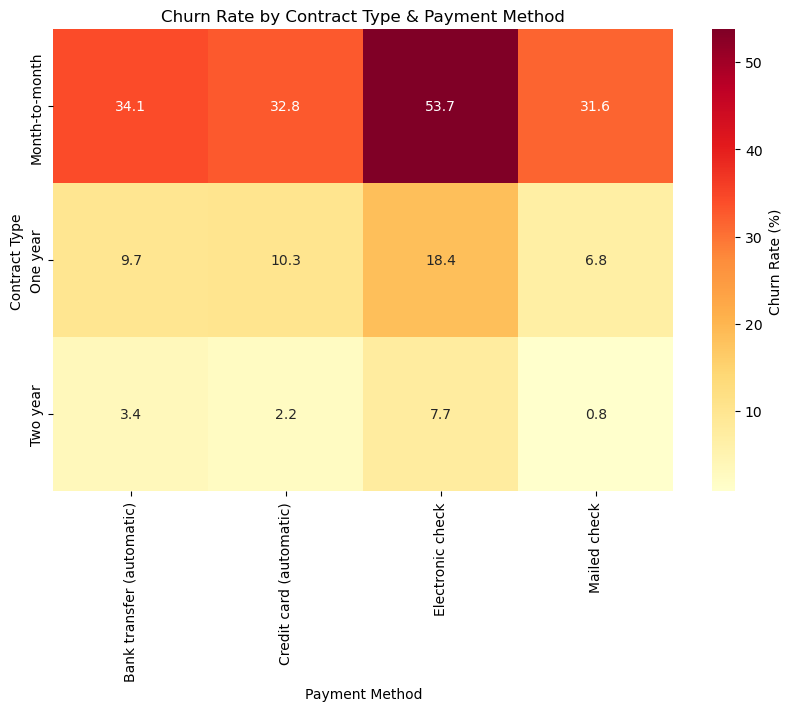

In [46]:
pivot = df_contract_payment.pivot(index="Contract", columns="Payment Method", values="churn_rate")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={"label": "Churn Rate (%)"})
plt.title("Churn Rate by Contract Type & Payment Method")
plt.ylabel("Contract Type")
plt.xlabel("Payment Method")
plt.show()

Customers on month to month contracts with electronic ckeck payments churn the most, 54%, while those on two yeears contract with automated payments churn with 2.24%. The riskiest group should be prioritised for retention efforts. Conversely, promoting longer-term contracta and auto-pay reduces churn.

### Summary - Key Findings
After analyzing the Telco dataset with SQL,several clear churn drivers emerged:
* Baseline: 27 % of customers churn (about 30 % of the monthly revenue).
* Contracts: Month-to-month contracts churn 43% vs 3% for two year contracts.
* Payments: Eletronic check users churn most, auto-pay customers churn least.
* Revenue Impact: Churners account for 30% of monthly revenue - which is direct bussiness risk.
* Tenure:  Nearly half of customers churn in the first 12 months but < 10% after 4 years.
* Network Services: Customers with more bundled services are more loyal.
* Risk Hotspot: Month-to-month + electronic check = highest churn group 54%